# Imports

In [17]:
import datetime
import functools
import os
import sys
from typing import Callable, Optional

if "PyTorch_VAE" not in sys.path:
    sys.path.append("PyTorch_VAE")

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from tqdm.notebook import tqdm, trange

from PyTorch_VAE import models
from diffusion_policy.common.sampler import get_val_mask
from diffusion_policy.dataset.pusht_image_dataset import PushTImageDataset

# Plotting

In [18]:
def plot_losses(train_losses, test_losses):
    # Plot train and test losses.
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(
        np.linspace(0, len(train_losses), len(test_losses)),
        test_losses,
        label="Test Loss",
    )
    # Remove outliers for better visualization
    # plt.ylim(0, 0.01)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Load dataset

In [19]:
path = "/nas/ucb/ebronstein/lsdp/diffusion_policy/data/pusht/pusht_cchi_v7_replay.zarr"
# path = "/home/tsadja/data_diffusion/pusht/pusht_cchi_v7_replay.zarr"
# path = '/home/matteogu/ssd_data/data_diffusion/pusht/pusht_cchi_v7_replay.zarr'

dataset = PushTImageDataset(path)
full_dataset = torch.from_numpy(dataset.replay_buffer["img"]).permute(0, 3, 1, 2)

In [20]:
def normalize_pn1(x, min_val, max_val):
    # Normalize to [0, 1]
    nx = (x - min_val) / (max_val - min_val)
    # Normalize to [-1, 1]
    return nx * 2 - 1


def denormalize_pn1(nx, min_val, max_val):
    # Denormalize from [-1, 1]
    x = (nx + 1) / 2
    # Denormalize from [0, 1]
    return x * (max_val - min_val) + min_val


# Make the state normalizer.
max_state = dataset.replay_buffer["state"].max(axis=0)
min_state = np.zeros_like(max_state)

In [21]:
class EpisodeDataset(Dataset):
    def __init__(
        self,
        dataset,
        n_obs_history=1,
        n_pred_horizon=1,
        episode_idxs=None,
        include_keys: Optional[list[str]] = None,
        process_fns: Optional[dict[str, Callable]] = None,
        device: str = "cpu",
    ):
        """
        Initialize the dataset with the main dataset object that contains
        the replay_buffer. Also, specify the lengths of observation history
        and prediction horizon.
        """
        self.dataset = dataset
        self.n_obs_history = n_obs_history
        self.n_pred_horizon = n_pred_horizon
        self.episode_idxs = list(episode_idxs)
        self.include_keys = set(include_keys) if include_keys is not None else None
        if not self.include_keys:
            raise ValueError("At least one key must be included in the dataset.")
        self.process_fns = process_fns
        self.device = device
        self.prepare_data()

    def prepare_data(self):
        """
        Preprocess the episodes to create a flat list of samples.
        Each sample is a tuple of dictionaries: (obs_history, pred_horizon).
        """
        self.samples = []

        if self.episode_idxs is None:
            self.episode_idxs = range(self.dataset.replay_buffer.n_episodes)

        for episode_idx in tqdm(self.episode_idxs, desc="Preparing data"):
            episode = self.dataset.replay_buffer.get_episode(episode_idx)

            obs = {}

            if self.include_keys is None or "img" in self.include_keys:
                img = episode["img"].transpose(0, 3, 1, 2)  # CHW format
                if "img" in self.process_fns:
                    img = self.process_fns["img"](img)
                obs["img"] = torch.tensor(img, dtype=torch.float32).to(self.device)

            if self.include_keys is None or "action" in self.include_keys:
                action = episode["action"]
                if "action" in self.process_fns:
                    action = self.process_fns["action"](action)
                obs["action"] = torch.tensor(action, dtype=torch.float32).to(
                    self.device
                )

            if self.include_keys is None or "state" in self.include_keys:
                state = episode["state"]
                if "state" in self.process_fns:
                    state = self.process_fns["state"](state)
                obs["state"] = torch.tensor(state, dtype=torch.float32).to(self.device)

            # Iterate through the episode to create samples with observation history and prediction horizon
            n_obs = len(list(obs.values())[0])
            for i in range(n_obs - self.n_obs_history - self.n_pred_horizon + 1):
                obs_history = {}
                pred_horizon = {}

                for key, value in obs.items():
                    obs_history[key] = value[i : i + self.n_obs_history]
                    pred_horizon[key] = value[
                        i
                        + self.n_obs_history : i
                        + self.n_obs_history
                        + self.n_pred_horizon
                    ]

                self.samples.append((obs_history, pred_horizon))

    def __len__(self):
        """
        Return the total number of samples across all episodes.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Return the idx-th sample from the dataset.
        """
        obs_history, pred_horizon = self.samples[idx]

        # Convert data to PyTorch tensors and ensure the data type is correct
        # for key, value in obs_history.items():
        #     obs_history[key] = torch.tensor(value, dtype=torch.float32)
        # for key, value in pred_horizon.items():
        #     pred_horizon[key] = torch.tensor(value, dtype=torch.float32)

        return obs_history, pred_horizon

# Diffusion

In [63]:
import math
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data


def train(model, train_loader, optimizer, scheduler, obs_key: str = "state"):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader, total=len(train_loader)):
        obs_history, pred_horizon = batch
        obs = obs_history[obs_key].cuda()
        loss = model.loss(obs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
    return train_losses


@torch.no_grad()
def eval_loss(model, data_loader, obs_key: str = "state"):
    model.eval()
    total_loss, total = 0, 0
    for batch in data_loader:
        obs_history, pred_horizon = batch
        obs = obs_history[obs_key].cuda()
        loss = model.loss(obs)
        num_data = obs.shape[0]
        total_loss += loss.item() * num_data
        total += num_data
    avg_loss = total_loss / total
    return avg_loss


def get_lr(step, total_steps, warmup_steps, use_cos_decay):
    if step < warmup_steps:
        mul = (step + 1) / warmup_steps
        return mul
    else:
        if use_cos_decay:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return (1 + math.cos(math.pi * progress)) / 2
        else:
            return 1


def train_epochs(model, train_loader, test_loader, train_args, obs_key: str = "state"):
    epochs, lr = train_args["epochs"], train_args["lr"]
    warmup_steps = train_args.get("warmup", 0)
    use_cos_decay = train_args.get("use_cos_decay", False)
    optimizer = optim.Adam(model.parameters(), lr)
    total_steps = epochs * len(train_loader)
    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay),
    )

    train_losses = []
    test_losses = [eval_loss(model, test_loader, obs_key=obs_key)]
    for epoch in tqdm(list(range(epochs))):
        train_loss = train(model, train_loader, optimizer, scheduler, obs_key=obs_key)
        train_losses.extend(train_loss)
        test_loss = eval_loss(model, test_loader, obs_key=obs_key)
        test_losses.append(test_loss)
        print(
            f"Epoch {epoch}, Test loss {test_loss:.4f}, Train loss {np.mean(train_loss):.4f}"
        )

    return np.array(train_losses), np.array(test_losses)


class Diffusion:
    def __init__(self, model, data_shape, encode_fn=None, decode_fn=None):
        self.model = model
        self.data_shape = data_shape
        self.encode_fn = encode_fn
        self.decode_fn = decode_fn

    def _get_alpha_sigma(self, t):
        return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)

    def _expand(self, t):
        for _ in range(len(self.data_shape)):
            t = t[..., None]
        return t

    def _noise(self, x, eps=None, t=None):
        if t is None:
            t = torch.rand(x.shape[0], dtype=torch.float32, device=x.device)
        if eps is None:
            eps = torch.randn_like(x)
        alpha_t, sigma_t = self._get_alpha_sigma(self._expand(t))
        # print("t:", t.shape)
        # print("expand(t):", self._expand(t).shape)
        # print("alpha_t:", alpha_t.shape)
        # print("sigma_t:", sigma_t.shape)
        # print("x:", x.shape)
        # print("eps:", eps.shape)
        x_t = alpha_t * x + sigma_t * eps
        return x_t, eps, t

    def _x_hat(self, x_t, eps_hat, t):
        alpha_t, sigma_t = self._get_alpha_sigma(self._expand(t))
        return (x_t - sigma_t * eps_hat) / alpha_t

    def loss(self, x, y=None):
        if self.encode_fn is not None:
            x = self.encode_fn(x)
        x_t, eps, t = self._noise(x)
        if y is not None:
            eps_hat = self.model(x_t, y, t)
        else:
            eps_hat = self.model(x_t, t)
        return torch.mean((eps_hat - eps) ** 2)

    @torch.no_grad()
    def sample(
        self,
        n,
        num_steps,
        clip_denoised=False,
        clip_noise=None,
        model_fn=None,
        cfg_val=None,
    ):
        model_fn = model_fn or self.model

        ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1, dtype=np.float32)
        x = torch.randn(n, *self.data_shape, dtype=torch.float32).cuda()
        for i in range(num_steps):
            t_cur = torch.full((n,), ts[i], dtype=torch.float32).cuda()
            t_next = torch.full((n,), ts[i + 1], dtype=torch.float32).cuda()

            alpha_cur, sigma_cur = self._get_alpha_sigma(self._expand(t_cur))
            alpha_next, sigma_next = self._get_alpha_sigma(self._expand(t_next))
            ddim_sigma = (sigma_next / sigma_cur) * torch.sqrt(
                1 - alpha_cur**2 / alpha_next**2
            )

            if cfg_val is None:
                eps_hat = model_fn(x, t_cur)
            else:
                eps_hat_cond = model_fn(x, t_cur)
                eps_hat_uncond = model_fn(x, t_cur, dropout_cond=True)
                eps_hat = eps_hat_uncond + cfg_val * (eps_hat_cond - eps_hat_uncond)

            x_hat = self._x_hat(x, eps_hat, t_cur)
            if clip_denoised:
                x_hat = torch.clamp(x_hat, -1, 1)

            noise = torch.randn_like(eps_hat)
            if clip_noise:
                noise = torch.clamp(noise, clip_noise[0], clip_noise[1])

            x = (
                alpha_next * x_hat
                + torch.sqrt((sigma_next**2 - ddim_sigma**2).clamp(min=0)) * eps_hat
                + ddim_sigma * noise
            )
        if self.decode_fn is not None:
            x = self.decode_fn(x)
        return x

    def __getattr__(self, name):
        if name in ["train", "eval", "parameters", "state_dict", "load_state_dict"]:
            return getattr(self.model, name)
        return self.__getattribute__(name)


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_hidden_layers, timestep_dim=1):
        super().__init__()
        self.timestep_dim = timestep_dim
        prev_dim = input_dim + timestep_dim
        net = []
        dims = [hidden_dim] * n_hidden_layers + [input_dim]
        for i, dim in enumerate(dims):
            net.append(nn.Linear(prev_dim, dim))
            if i < len(dims) - 1:
                net.append(nn.ReLU())
            prev_dim = dim
        self.net = nn.Sequential(*net)

    def forward(self, x, t):
        """Run a forward pass.

        Args:
            x (torch.Tensor): Data with shape [batch_size, n_history, input_dim].
            t (torch.Tensor): Time embedding with shape [batch_size].
        """
        flat_x = x.flatten(1)  # [batch_size, n_history * input_dim]
        xt = torch.cat([flat_x, t[:, None]], dim=1)
        out = self.net(xt)
        return out.reshape(x.shape)

## Train

In [39]:
# Make train and val loaders
val_mask = get_val_mask(dataset.replay_buffer.n_episodes, 0.1)
val_idxs = np.where(val_mask)[0]
train_idxs = np.where(~val_mask)[0]

# Make the episode dataset and create a DataLoader.
batch_size = 256
n_obs_history = 5
n_pred_horizon = 0

state_normalizer = functools.partial(
    normalize_pn1, min_val=min_state, max_val=max_state
)
process_fns = {"state": state_normalizer}
include_keys = ["state"]

train_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=train_idxs,
    include_keys=include_keys,
    process_fns=process_fns,
    device="cuda",
)
val_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=val_idxs,
    include_keys=include_keys,
    process_fns=process_fns,
    device="cuda",
)
train_loader = torch.utils.data.DataLoader(
    train_episode_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_episode_dataset, batch_size=batch_size, shuffle=False
)

Preparing data:   0%|          | 0/185 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/21 [00:00<?, ?it/s]

In [40]:
# Normalization sanity check
# obs_history, pred_horizon = next(iter(train_loader))

# for key, value in obs_history.items():
#     print(key, value.shape)
#     print("min:", value.min(axis=0), "max:", value.max(axis=0))

# for key, value in pred_horizon.items():
#     print(key, value.shape)

In [64]:
# wandb_run = wandb.init(project='check_norms', name='first_run', reinit=True)
wandb_run = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

STATE_DIM = 5
input_dim = n_obs_history * STATE_DIM
hidden_dim = 512
n_hidden_layers = 4

mlp = MLP(input_dim, hidden_dim, n_hidden_layers, timestep_dim=1).to(device)
model = Diffusion(mlp, (n_obs_history, STATE_DIM))

train_losses, test_losses = train_epochs(
    model,
    train_loader,
    val_loader,
    dict(epochs=100, lr=1e-3, warmup=100, use_cos_decay=True),
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 0, Test loss 0.2401, Train loss 0.5832


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1, Test loss 0.1903, Train loss 0.2080


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2, Test loss 0.1464, Train loss 0.1617


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3, Test loss 0.1503, Train loss 0.1434


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4, Test loss 0.1250, Train loss 0.1314


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5, Test loss 0.1326, Train loss 0.1308


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6, Test loss 0.1212, Train loss 0.1247


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7, Test loss 0.1290, Train loss 0.1225


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8, Test loss 0.1245, Train loss 0.1229


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9, Test loss 0.1203, Train loss 0.1189


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10, Test loss 0.1131, Train loss 0.1178


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 11, Test loss 0.1175, Train loss 0.1182


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 12, Test loss 0.1314, Train loss 0.1182


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13, Test loss 0.1114, Train loss 0.1186


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14, Test loss 0.1224, Train loss 0.1150


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 15, Test loss 0.1071, Train loss 0.1130


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 16, Test loss 0.1181, Train loss 0.1114


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 17, Test loss 0.1041, Train loss 0.1130


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 18, Test loss 0.1129, Train loss 0.1103


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 19, Test loss 0.1102, Train loss 0.1122


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 20, Test loss 0.1091, Train loss 0.1086


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 21, Test loss 0.1208, Train loss 0.1092


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 22, Test loss 0.1059, Train loss 0.1084


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 23, Test loss 0.1115, Train loss 0.1073


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 24, Test loss 0.1057, Train loss 0.1086


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 25, Test loss 0.1016, Train loss 0.1069


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 26, Test loss 0.1043, Train loss 0.1083


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 27, Test loss 0.1138, Train loss 0.1062


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 28, Test loss 0.0987, Train loss 0.1087


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 29, Test loss 0.1079, Train loss 0.1048


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 30, Test loss 0.1123, Train loss 0.1054


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 31, Test loss 0.1041, Train loss 0.1055


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 32, Test loss 0.1095, Train loss 0.1046


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 33, Test loss 0.1102, Train loss 0.1057


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 34, Test loss 0.1117, Train loss 0.1057


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 35, Test loss 0.1051, Train loss 0.1059


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 36, Test loss 0.1052, Train loss 0.1040


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 37, Test loss 0.1095, Train loss 0.1044


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 38, Test loss 0.0979, Train loss 0.1023


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 39, Test loss 0.1030, Train loss 0.1026


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 40, Test loss 0.1023, Train loss 0.1001


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 41, Test loss 0.1027, Train loss 0.1031


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 42, Test loss 0.0974, Train loss 0.1024


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 43, Test loss 0.1035, Train loss 0.1027


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 44, Test loss 0.1023, Train loss 0.1013


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 45, Test loss 0.1014, Train loss 0.1008


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 46, Test loss 0.1005, Train loss 0.1001


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 47, Test loss 0.0961, Train loss 0.1012


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 48, Test loss 0.1048, Train loss 0.1018


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 49, Test loss 0.1006, Train loss 0.1003


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 50, Test loss 0.0994, Train loss 0.1005


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 51, Test loss 0.0970, Train loss 0.0992


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 52, Test loss 0.0967, Train loss 0.1001


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 53, Test loss 0.0995, Train loss 0.0997


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 54, Test loss 0.1017, Train loss 0.0983


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 55, Test loss 0.0970, Train loss 0.0975


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 56, Test loss 0.0996, Train loss 0.0994


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 57, Test loss 0.0982, Train loss 0.0979


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 58, Test loss 0.0933, Train loss 0.0981


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 59, Test loss 0.1012, Train loss 0.0982


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 60, Test loss 0.1012, Train loss 0.0984


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 61, Test loss 0.0977, Train loss 0.0968


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 62, Test loss 0.1012, Train loss 0.0967


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 63, Test loss 0.0975, Train loss 0.0958


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 64, Test loss 0.0949, Train loss 0.0966


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 65, Test loss 0.0932, Train loss 0.0967


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 66, Test loss 0.1010, Train loss 0.0983


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 67, Test loss 0.0979, Train loss 0.0954


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 68, Test loss 0.0922, Train loss 0.0947


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 69, Test loss 0.0921, Train loss 0.0950


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 70, Test loss 0.0939, Train loss 0.0951


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 71, Test loss 0.0910, Train loss 0.0951


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 72, Test loss 0.0944, Train loss 0.0957


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 73, Test loss 0.0975, Train loss 0.0942


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 74, Test loss 0.0904, Train loss 0.0935


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 75, Test loss 0.0936, Train loss 0.0939


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 76, Test loss 0.0920, Train loss 0.0944


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 77, Test loss 0.0938, Train loss 0.0929


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 78, Test loss 0.0908, Train loss 0.0931


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 79, Test loss 0.0931, Train loss 0.0942


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 80, Test loss 0.0913, Train loss 0.0943


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 81, Test loss 0.0961, Train loss 0.0938


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 82, Test loss 0.0855, Train loss 0.0940


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 83, Test loss 0.0925, Train loss 0.0940


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 84, Test loss 0.0903, Train loss 0.0929


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 85, Test loss 0.0942, Train loss 0.0956


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 86, Test loss 0.0910, Train loss 0.0917


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 87, Test loss 0.0912, Train loss 0.0922


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 88, Test loss 0.0944, Train loss 0.0931


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 89, Test loss 0.0911, Train loss 0.0913


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 90, Test loss 0.0908, Train loss 0.0937


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 91, Test loss 0.0898, Train loss 0.0928


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 92, Test loss 0.0933, Train loss 0.0924


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 93, Test loss 0.0915, Train loss 0.0920


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 94, Test loss 0.0920, Train loss 0.0925


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 95, Test loss 0.0923, Train loss 0.0913


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 96, Test loss 0.0919, Train loss 0.0929


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 97, Test loss 0.0887, Train loss 0.0917


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 98, Test loss 0.0943, Train loss 0.0915


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 99, Test loss 0.0921, Train loss 0.0916


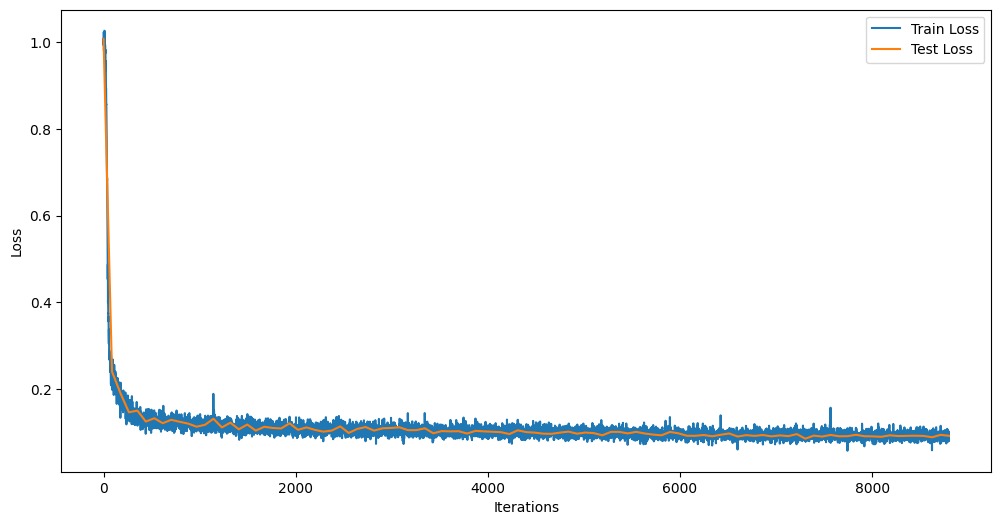

In [65]:
plot_losses(train_losses, test_losses)

In [66]:
# Save the model
# save_dir = "models/diffusion/pusht_mlp_5x512/2024-04-15"
save_dir = None
if save_dir is not None:
    os.makedirs(save_dir, exist_ok=False)
    diffusion.save(os.path.join(save_dir, "diffusion_model_final.pt"))
    np.save(os.path.join(save_dir, "train_losses.npy"), train_losses)
    np.save(os.path.join(save_dir, "test_losses.npy"), test_losses)

## Sample

In [67]:
num_samples = 10000
num_steps_list = [512]
normalized_samples = []
clip_noise = (-3, 3)
for num_steps in num_steps_list:
    normalized_samples.append(
        model.sample(
            num_samples, num_steps=num_steps, clip_denoised=True, clip_noise=clip_noise
        )
        .cpu()
        .numpy()
    )
normalized_samples = np.stack(normalized_samples, axis=0)

In [68]:
# TODO: remove NaNs?
for norm_samples_i in normalized_samples:
    print(norm_samples_i.min(), norm_samples_i.max())
    print(
        norm_samples_i[~np.isnan(norm_samples_i)].min(),
        norm_samples_i[~np.isnan(norm_samples_i)].max(),
    )

nan nan
-0.99981964 1.000333


In [69]:
samples = denormalize_pn1(normalized_samples, min_state, max_state)

In [70]:
# TODO: remove NaNs?
for samples_i in samples:
    print(samples_i.min(), samples_i.max())
    print(
        samples_i[~np.isnan(samples_i)].min(),
        samples_i[~np.isnan(samples_i)].max(),
    )

nan nan
0.0005666203 510.9848


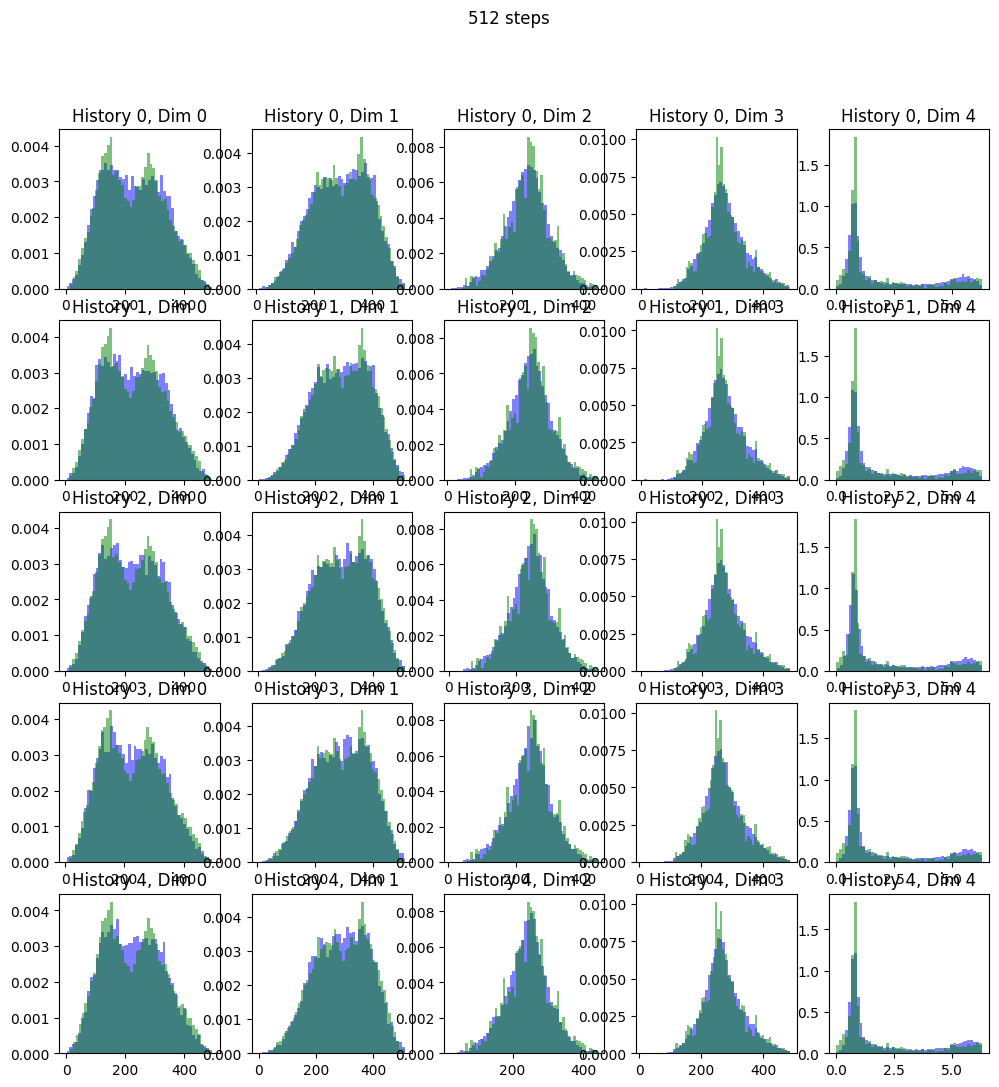

In [71]:
# Plot histogram of each dimension of the samples
for i, steps in enumerate(num_steps_list):
    step_samples = samples[i]  # [num_samples, n_history, dim]
    n_history = step_samples.shape[1]
    dim = step_samples.shape[2]

    fig, ax = plt.subplots(n_history, dim, figsize=(12, 12))

    for i in range(n_history):
        for j in range(dim):

            ax[i, j].hist(
                step_samples[:, i, j],
                density=True,
                bins=50,
                color="blue",
                alpha=0.5,
                # label=f"samples {i}",
            )
            ax[i, j].hist(
                dataset.replay_buffer["state"][:, j],
                density=True,
                bins=50,
                color="green",
                alpha=0.5,
                # label=f"replay {i}",
            )
            ax[i, j].set_title(f"History {i}, Dim {j}")
            # ax[i, j].legend()

    fig.suptitle(f"{steps} steps")
    plt.show()

In [72]:
diff_states = []
for obs_history, pred_horizon in train_loader:
    state = obs_history["state"].detach().cpu().numpy()
    diff_states.append(np.diff(state, axis=1))

diff_states = np.concatenate(diff_states, axis=0)

In [73]:
diff_samples = np.diff(samples, axis=2)

In [74]:
nan_exists = np.isnan(diff_samples).any(axis=(2, 3))
diff_samples_no_nan = diff_samples[:, ~nan_exists[0]]

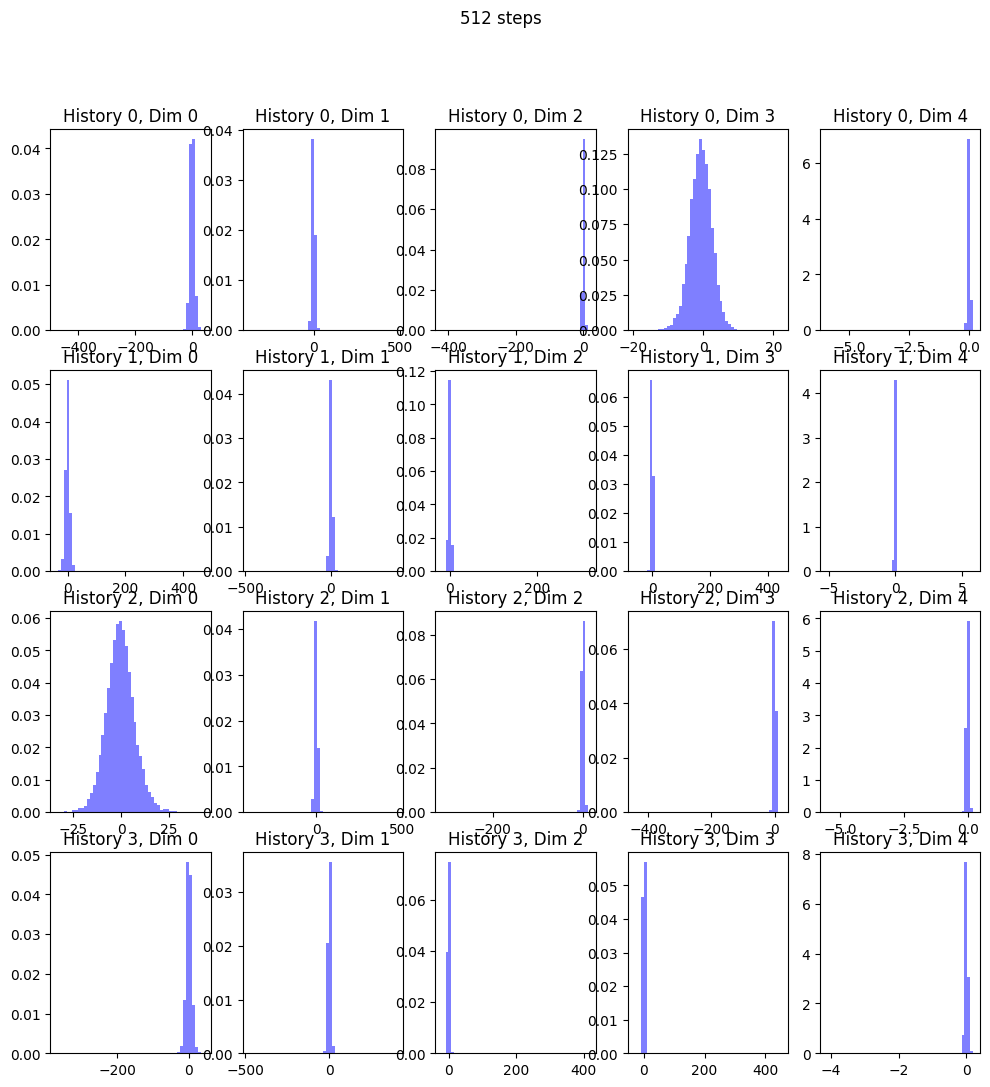

In [75]:
# Plot histogram of each dimension of the samples
for i, steps in enumerate(num_steps_list):
    step_diff_samples = diff_samples_no_nan[i]  # [num_samples, n_history, dim]
    n_history = step_diff_samples.shape[1]
    dim = step_diff_samples.shape[2]

    fig, axs = plt.subplots(n_history, dim, figsize=(12, 12))

    for i in range(n_history):
        for j in range(dim):
            ax = axs[i, j]
            ax.hist(
                step_diff_samples[:, i, j],
                density=True,
                bins=50,
                color="blue",
                alpha=0.5,
                # label=f"samples {i}",
            )

            ax.set_title(f"History {i}, Dim {j}")
            # ax.legend()

    fig.suptitle(f"{steps} steps")
    plt.show()

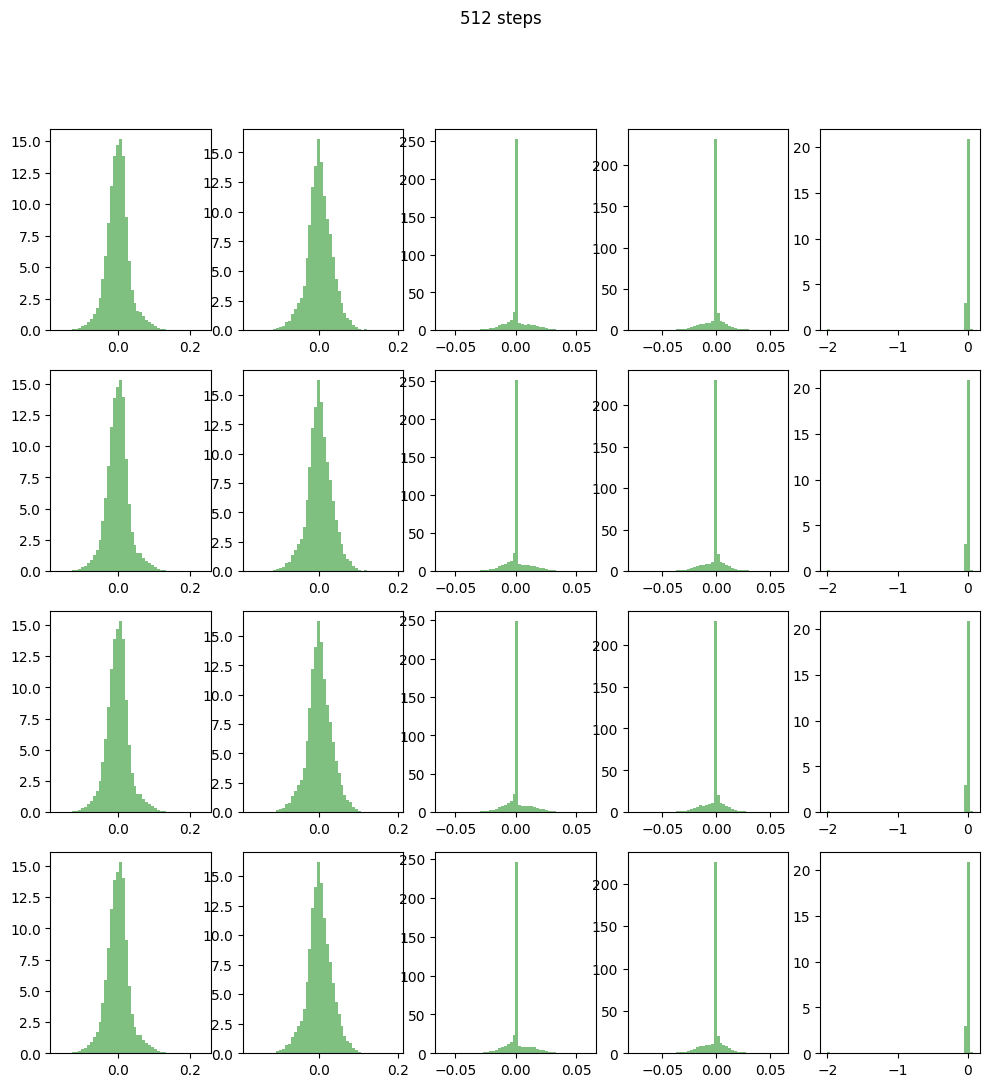

In [56]:
# Plot histogram of each dimension of the samples
for i, steps in enumerate(num_steps_list):
    step_diff_samples = diff_samples_no_nan[i]  # [num_samples, n_history, dim]
    n_history = step_diff_samples.shape[1]
    dim = step_diff_samples.shape[2]

    fig, axs = plt.subplots(n_history, dim, figsize=(12, 12))

    for i in range(n_history):
        for j in range(dim):
            ax = axs[i, j]
            ax.hist(
                diff_states[:, i, j],
                density=True,
                bins=50,
                color="green",
                alpha=0.5,
                # label=f"replay {i}",
            )

            # ax.set_title(f"History {i}, Dim {j}")
            # ax.legend()

    fig.suptitle(f"{steps} steps")
    plt.show()

### Debug sampling

In [ ]:
for p in diffusion.model.parameters():
    # print(p)
    if torch.isnan(p).any():
        print("NaNs in the parameters.")
    else:
        param_norm = p.norm(2)
        print(param_norm)

tensor(14.9996, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(3.5165, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(18.1615, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.8481, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(17.6145, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.7344, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(16.9889, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.7030, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(4.4330, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.1216, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
